# L-SRTDE algorithm

Information from [original paper](https://ieeexplore.ieee.org/document/10611907)

## Features

### Rank

$rank_i=e^{-kp*i/n}$

- $kp$ is a selective pressure parameter (the selective pressure was shown to improve the convergence speed)
- $i = 1,2,...,N$

### Mutation strategy from [L-NTADE](https://www.mdpi.com/2227-7390/10/24/4666)
It`s called *r-new-to-ptop/n/t*

$u_{i,j}=x^{new}_{r_1,j} + F*(x^{top}_{pbest,j} - x^{new}_{i,j}) + F*(x^{new}_{r_2,j} - x^{top}_{r_3,j})$

- $x^{new}$ are newest solutions in iteration
- $x^{top}$ are top solutions in done iterations
- $r_1$ and $r_13$ parameters are chosen randomly
- $r_2$ is chosen with rank-based selective pressure with $kp=3$
- $pbest$ is chosen from pb% best solutions from the top population ($x^{top}$)

### Crossover strategy from [L-NTADE](https://www.mdpi.com/2227-7390/10/24/4666)

$x_{nc}=
\left\{
\begin{aligned}
  &u_i,  \textrm{if} f(u_i) \le f(x^{new}_{r_1})\\
  &x_{nc}, \textrm{if} f(u_i) > f(x^{new}_{r_1})
\end{aligned}
\right.$

- $nc$ is an index iterated after every successful replacement, if $nc>N$ then $nc=1$
- $u_i$ is the trial vector, $x^{new}_{r_1}$ is the basic vector
- if the trial vector $u_i$ is better than the basic vector $x^{new}_{r_1}$ then it replaces individual with $nc$ index, not with $i$ index
- all successful vectors are stored in temporary storage $x^{temp}$ with their fitness values
- at the end of iteration $x^{temp}$ and $x^{top}$ solutions are combined and sorted by fitness values. Then the best $N$ solutions are chosen and are placed to new $x^{top}$
- the length of $x^{top}$ must be equal to $N$

### Scaling factor adaptation for $F$ (first feature)

$mF=0.4 + 0.25*tanh(5*SR)$

- $SR=NS/N$, $NS$ is the number of successful solutions (number of times the selection worked)
- $mF$ was proposed as hyper-heuristic approach for $F$ scaling $F=randn(mF,0.02)$

### Success rate for $pb$ parameter

$pb=0.7*e^{-7*SR}$

- if the success rate $SR$ is close to 0, then $pbest$ index s chose from 70% of the best solutions
- if the success rate grows, the $pb$ decreases, and focuses on smaller number of the best solutions (the best of the best)

### Repaired crossover rate $Cr$

$Cr=randn(M_{Cr,k},0.05)$

## Pseudocode

1. Input: $D$, $NFE_{max}$, $N_{max}$, target function $f(x)$
2. Output: $x^{top}_{best}$, $f(x^{top}_{best})$
3. Set $N=N_{max}$, $N_{min}=4$, $H=5$, $M_{Cr,r}=1$
4. Set $SR=0.5$, $k=1$, $g=0$, $nc=1$, $kp=3$
5. Initialize population ($x^{new}_{1,j},...,x^{new}_{N,j}$) randomly
6. Calculate $f(x^{new})$
7. Copy $x^{new}$ to $x^{top}$, $f(x^{new})$ to $f(x^{top})$
8. **while** $NFE < NFE_{max}$ **do**
    1. Set $S_{Cr}=\emptyset$, $S_{\Delta f}=\emptyset$
    2. Sort $x^{new}$ and $f(x^{new})$
    3. Assign ranks for $x^{new}$
    4. **for** $i=1$ to $N^{g}$ **do**
        1. $mF=0.4 + 0.25*th(5*SR)$
        2. **repeat**
            1. $F_i=randn(mF,0.02)$
        3. **until** $F_i \in (0,1)$
        4. Current memory index $r=randi[1,H]$
        5. Crossover rate $Cr_i=randn(M_{Cr,r},0.05)$
        6. $Cr_i=min(1,max(0,Cr))$
        7. $r_1=randi(N^g)$
        8. $pb=0.7*e^{-7*SR}$
        9. **repeat**
            1. $pbest=randi(1,N^g*pb)$
            2. Generate $r_2$ with rank-based selection
            3. $r_3=randi(1,N^g)$
        10. **until** indexes $r_1$, $r_2$, $r_3$ and $pbest$ are different
        11. Apply mutation to produce $u_i$ with $F_i$
        12. Apply binomial crossover to produce $u_i$ with $Cr_i$
        13. Calculate actual rater $Cr_a$
        14. Apply bound constraint handling method
        15. Calculate $f(u_i)$
        16. **if** $f(u_i) < f(x^{new}_{r_1})$ **then**
            1. $Cr_a \rightarrow S_{Cr}$
            2. $(f(x^{new}_{r_1})-f(u_i)) \rightarrow S_{\Delta f} $
            3. $u_i \rightarrow x^{temp}$
            4. $f(x^{temp}_m) = f(u_i)$
            5. $x^{new}_{nc}=u_i$
            6. $f(x^{new}_{nc}) = f(u_i)$
            7. $nc=mod(nc+1, N^{g}), m = m + 1$
        17. **end if**
    5. **end for**
    6. Get $N^{g+1}$ with $LPSR$
    7. Join together $x^{top}$ and $x^{temp}$ and sort
    8. Copy $N^{g+1}$ best vectors back to $x^{top}$
    9. **if** $N^{g} > N^{g+1}$ **then**
        1. Remove worst individuals from $x^{new}$
    10. **end if**
    11. Update $M_{Cr,k}$
    12. $k=mod(k+1,H), g=g+1, m=1$
9. **end while**
10. Return $x^{top}_{best}, f(x^{top}_{best})$

## Python implementation

In [1]:
from algorithm import Algorithm

### Load GNBG class
Functions for GNBG 2024

In [2]:
import os
_root_path = os.getcwd()
os.chdir('..')
from _gnbg_functions.gnbg_for_json import GNBG
os.chdir(_root_path)

### Run and visualize

In [3]:
import time
import traceback

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Настройки
total_n_runs = 1

# Считаем для первых 16 функций
max_n_funcs = 16
population_size = 10

In [4]:
# Результаты всех запусков

# Ошибки
res_errors = np.zeros((max_n_funcs, total_n_runs, 1001))
# Минимумы
res = np.zeros((max_n_funcs, total_n_runs, 1001))
# Показатели успешности (Success Rate)
sr_res = np.zeros((max_n_funcs, total_n_runs, 1001))

# Найденные оптимумы
optimums = np.zeros(max_n_funcs)

# Необходимые оптимумы
fopts = np.zeros(max_n_funcs)

# Запуск алгоритма и сбор результатов
for func_num in range(0, max_n_funcs):
    try:
        gnbg = GNBG(func_num+1)
        fopt = gnbg.optimum_value
        fopts[func_num] = fopt
        
        _optimums = np.zeros(total_n_runs)

        for run in range(total_n_runs):
            t0 = time.time()
            print(f"\nRunning algorithm on {gnbg}, run {run + 1}")
            print(f'Function best value: {fopt}')
            
            # Инициализация алгоритма
            optz = Algorithm(
                fitness_function=gnbg.fitness,
                population_size=population_size * gnbg.dimension,
                problem_dimension=gnbg.dimension,
                verbose=False
            )
            
            # Настраиваем максимальное количество вызовов целевой функции
            optz._global_variables.max_eval_func_calls = gnbg.max_evals
            _, optimum = optz()
            
            # Читаем результаты работы
            _optimums[run] = optimum
            res_errors[func_num, run] = optz._global_variables.error_array
            res[func_num, run] = optz._global_variables.best_of_best_array
            sr_res[func_num, run] = optz._global_variables.sr_array
            
            print(f'Algorithm best value: {optimum}')
            print(f'\tElapsed time: {round(time.time()-t0, 2)} sec')
        optimums[func_num] = np.mean(_optimums)
    except Exception as e:
        print(f'\t### Error in function {func_num}: {e}')
        print(f'\t### Traceback: {traceback.format_exc()}')


Running algorithm on GNBG Function 1 (D=30, comp_num=1), run 1
Function best value: -1082.0
Algorithm best value: 37.28898545705747
	Elapsed time: 122.13 sec

Running algorithm on GNBG Function 2 (D=30, comp_num=1), run 1
Function best value: -703.13
Algorithm best value: 48.483621494738756
	Elapsed time: 115.14 sec

Running algorithm on GNBG Function 3 (D=30, comp_num=1), run 1
Function best value: -357.58
Algorithm best value: 75.41166912919104
	Elapsed time: 115.81 sec

Running algorithm on GNBG Function 4 (D=30, comp_num=1), run 1
Function best value: -382.62
Algorithm best value: 140.0998296723236
	Elapsed time: 125.01 sec

Running algorithm on GNBG Function 5 (D=30, comp_num=1), run 1
Function best value: -337.51
Algorithm best value: 212.10462823356198
	Elapsed time: 132.99 sec

Running algorithm on GNBG Function 6 (D=30, comp_num=1), run 1
Function best value: -186.86
Algorithm best value: 41.78760105767282
	Elapsed time: 257.99 sec

Running algorithm on GNBG Function 7 (D=30,

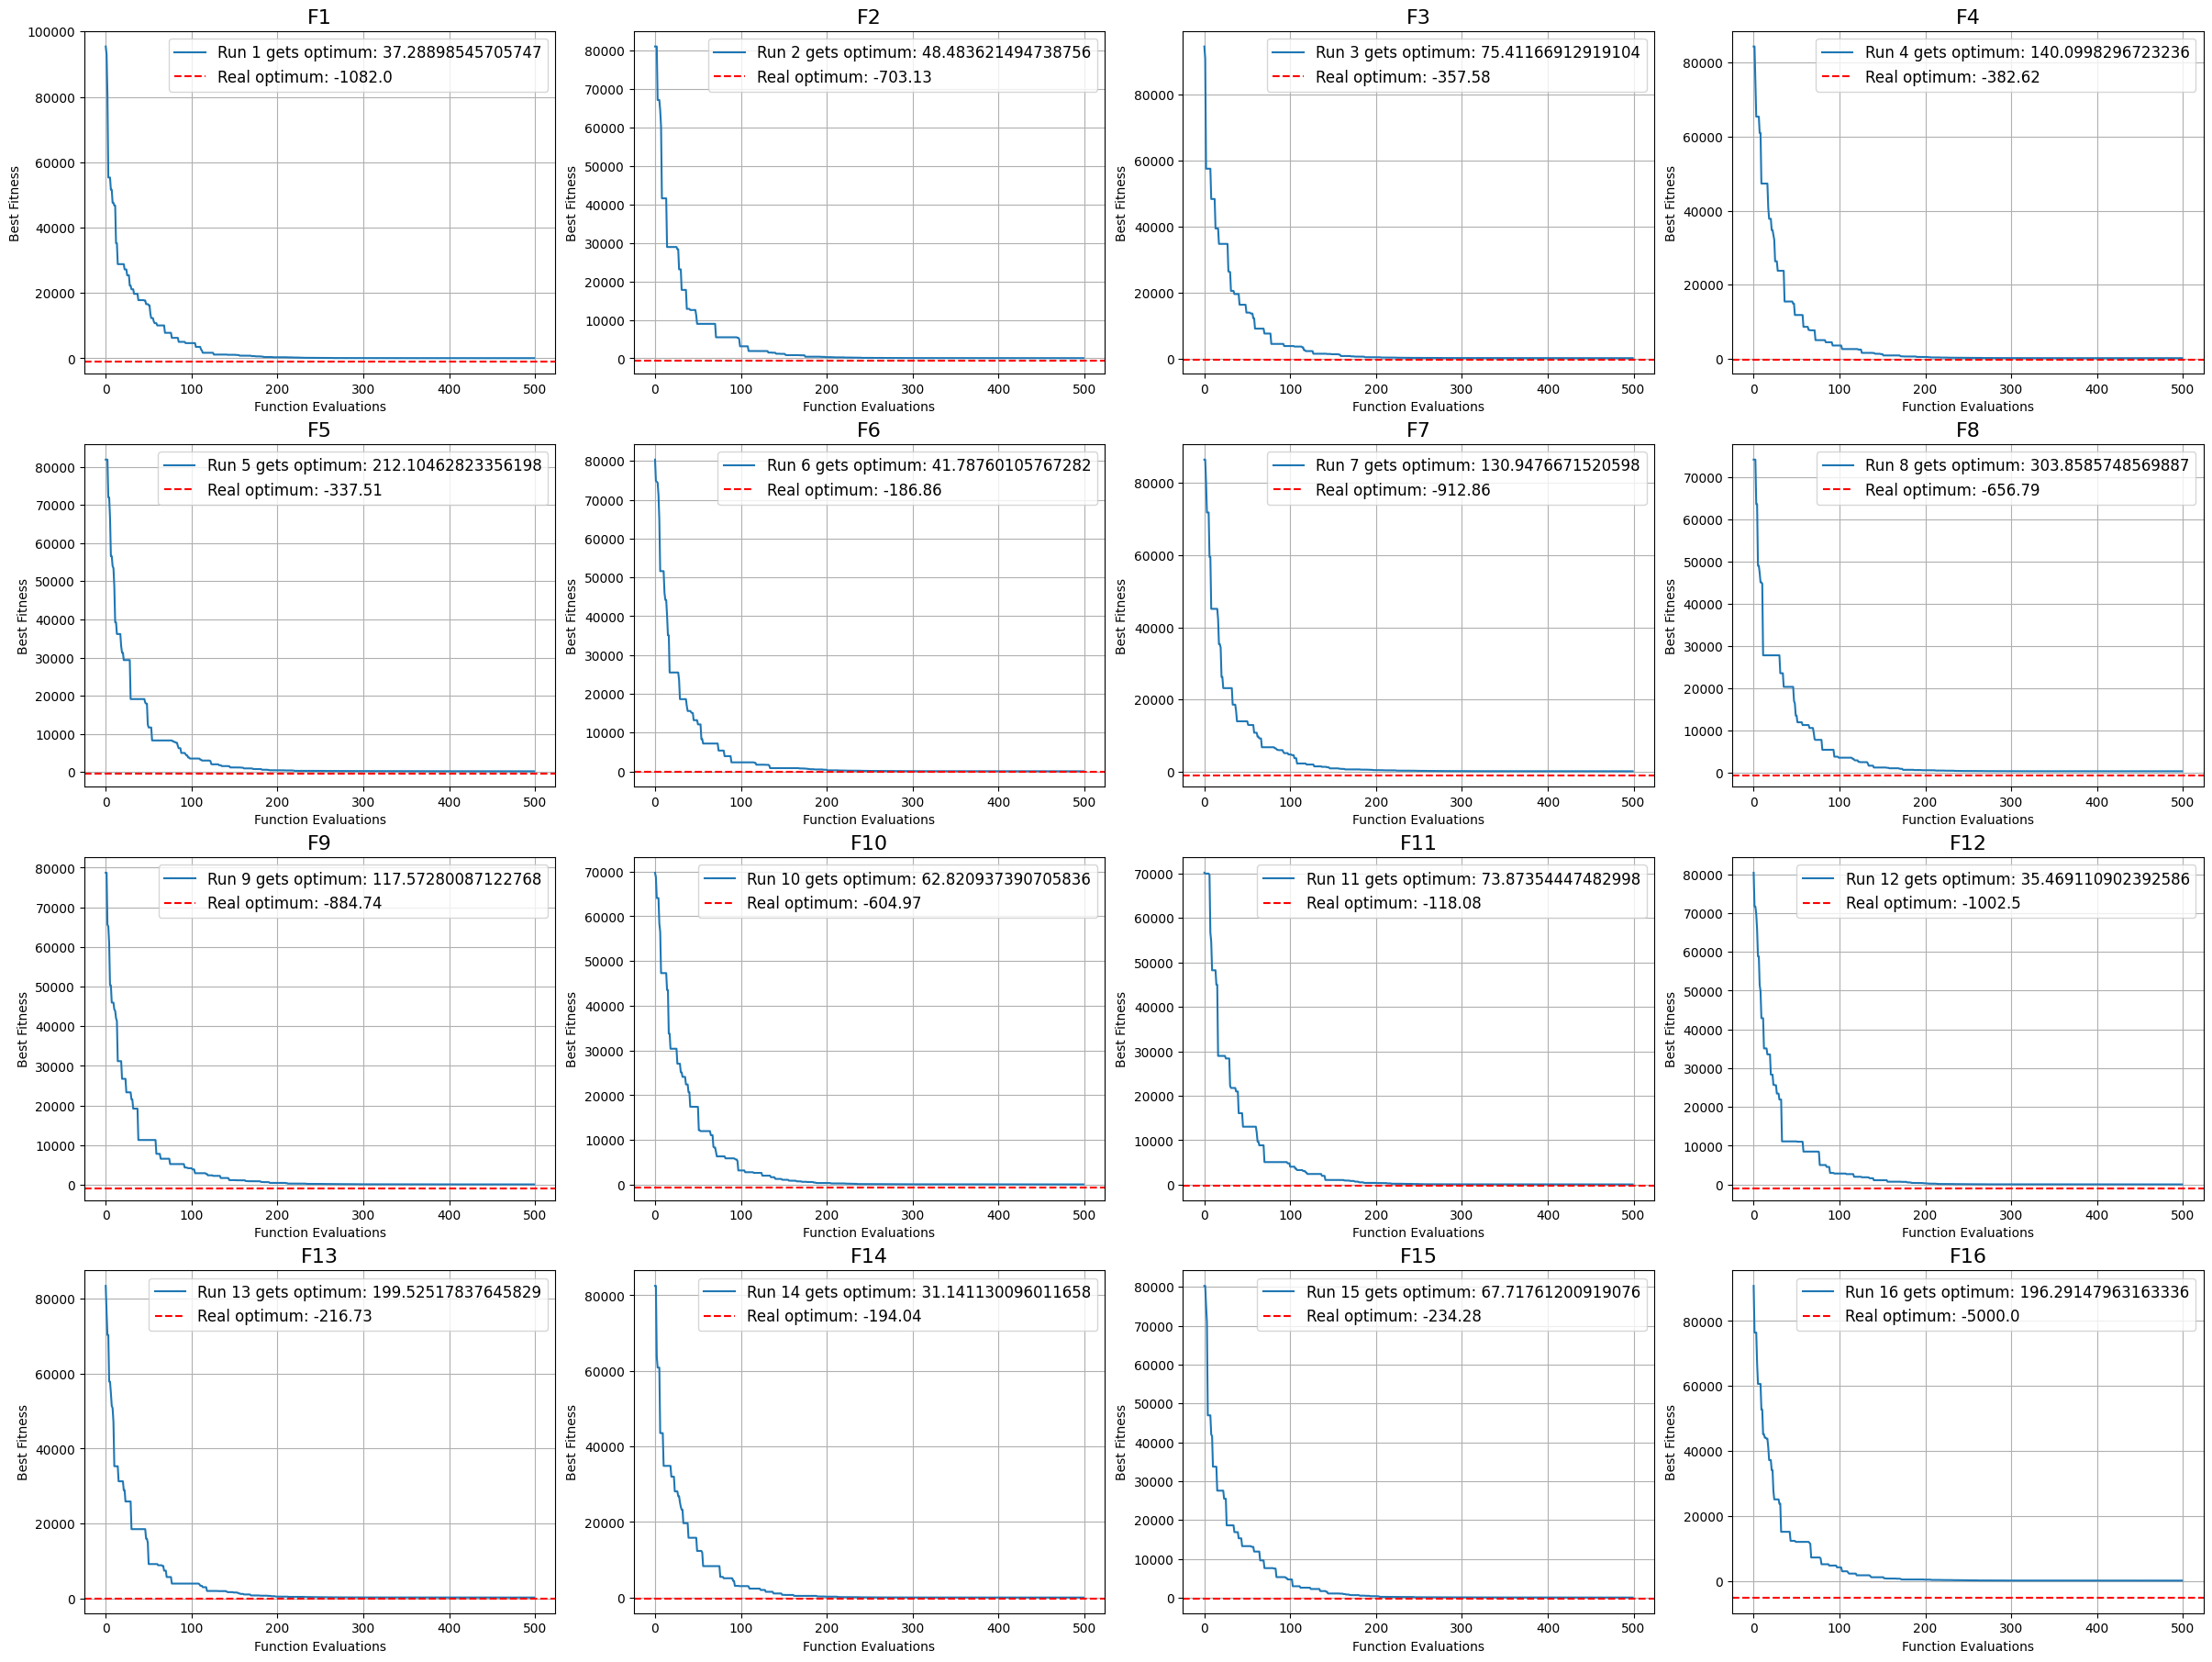

In [5]:
is_need_log = False
is_need_saving = False

fig = plt.figure(figsize=(24, 18), constrained_layout=True)
gs = fig.add_gridspec(4, 4)
# Количество отображаемых эпох
limit = 500

# Визуализация
for func_num in range(max_n_funcs):
    row = (func_num) // 4
    col = (func_num) % 4
    ax = fig.add_subplot(gs[row, col])
    optimum = optimums[func_num]
    for run in range(total_n_runs):
        if is_need_log:
            ax.semilogy(res[func_num, run, :limit], label=f"Run {func_num+1} gets optimum: {optimum}")
        else:
            ax.plot(res[func_num, run, :limit], label=f"Run {func_num+1} gets optimum: {optimum}")
    
    ax.set_title(f"F{func_num+1}", fontsize=16)
    ax.set_xlabel("Function Evaluations")
    ax.set_ylabel("Best Fitness")
    
    ax.axhline(
        y=fopts[func_num], 
        color='red', 
        linestyle='--',
        label=f'Real optimum: {round(fopts[func_num], 2)}'
    )
    
    ax.grid(True)
    ax.legend(fontsize='large')

if is_need_saving:
    plt.savefig('python_l_strde_on_gnbg.png')
plt.show()

### Table of results

In [10]:
import copy
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

res_table = pd.DataFrame(columns=[
    'Function', 'Absolute error', 
    'Required function evaluations to acceptance threshold',
    'Success rate'
])

row_template = {
    'Function': None,
    'Absolute error': None,
    'Required function evaluations to acceptance threshold': None,
    'Success rate': None
}

for func_i in range(max_n_funcs):
    _row = copy.deepcopy(row_template)
    _row['Function'] = f'F{func_i+1}'
    _row['Absolute error'] = str(round(np.mean(res_errors[func_i,:]), 6)) \
        + u"\u00B1" + str(round(np.std(res_errors[func_i,:]), 6))

    _row['Required function evaluations to acceptance threshold'] = str(round(np.mean(res_errors[func_i,:,-1]), 6)) \
        + u"\u00B1" + str(round(np.std(res_errors[func_i,:,-1]), 6))
    
    _row['Success rate'] = str(round(np.mean(sr_res[func_i,:]), 6)) \
        + u"\u00B1" + str(round(np.std(sr_res[func_i,:]), 6))
    
    res_table = pd.concat([res_table, pd.DataFrame([_row])], axis=0, ignore_index=True)
    
res_table

,Function,Absolute error,Required function evaluations to acceptance threshold,Success rate
0,F1,2170.076072±8248.469362,0.0±0.0,0.19246±0.053577
1,F2,2076.515643±8180.423947,0.0±0.0,0.192111±0.050692
2,F3,2331.080636±8644.148668,0.0±0.0,0.18966±0.050702
3,F4,2363.096383±8931.095362,0.0±0.0,0.193438±0.051945
4,F5,2427.26314±8588.207746,0.0±0.0,0.19044±0.050881
5,F6,2036.940582±8193.394905,0.0±0.0,0.193974±0.053769
6,F7,2318.326124±8678.710453,0.0±0.0,0.193753±0.053579
7,F8,2389.363862±7701.766023,0.0±0.0,0.194622±0.053833
8,F9,2089.849759±7634.42476,0.0±0.0,0.187529±0.048952
9,F10,2309.723603±8247.836651,0.0±0.0,0.191186±0.049736
